In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/ECR_Project/dataset/'


Mounted at /content/drive


In [2]:
from skimage.feature import hog, local_binary_pattern, canny
from skimage.color import rgb2gray

def extract_hog_features(images):
    hog_features = []
    for img in images:
        gray_img = rgb2gray(img)
        # Extract HOG features
        features, _ = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        gray_img = rgb2gray(img)
        # Compute LBP features
        lbp = local_binary_pattern(gray_img, P=8, R=1, method='uniform')
        # Flatten the LBP histogram as features
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        lbp_features.append(lbp_hist / np.sum(lbp_hist))  # Normalize the histogram
    return np.array(lbp_features)


def extract_edge_features(images):
    edge_features = []
    for img in images:
        gray_img = rgb2gray(img)
        # Apply Canny edge detection
        edges = canny(gray_img, sigma=1.0)
        # Flatten edges as features
        edge_features.append(edges.ravel())
    return np.array(edge_features)

def extract_combined_features(images):
    hog_features = extract_hog_features(images)
    lbp_features = extract_lbp_features(images)
    edge_features = extract_edge_features(images)


    combined_features = np.hstack((hog_features, lbp_features, edge_features))
    return combined_features





In [3]:
import os
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern, canny
from skimage.color import rgb2gray

def preprocess_image(image_path, target_size=(256, 256)):
    # Read image in color (BGR) for HOG and LBP
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    img = cv2.resize(img, target_size)

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray_img = cv2.equalizeHist(gray_img)

    # Edge detection using canny
    edges = cv2.Canny(gray_img, 100, 200)

    return img, edges.flatten()

def load_dataset(data_dir):
    """Load images from the dataset directory and create features and labels."""
    images = []
    edge_features = []
    labels = []
    class_names = sorted(os.listdir(data_dir))

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)

            # Preprocess the image
            img, feature_vector = preprocess_image(image_path)

            # Check if preprocessing was successful
            if img is not None:
                images.append(img)
                edge_features.append(feature_vector)
                labels.append(label)

    return np.array(images), np.array(edge_features), np.array(labels), class_names


# Load dataset from the directory
data_dir = "/content/drive/MyDrive/ECR_Project/dataset/"
images, edge_features, y, class_names = load_dataset(data_dir) # changed here to reflect the change in output of load_dataset

# split into training and testing sets
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42) # changed here, now using images

X_train_edge_features, X_test_edge_features, _, _ = train_test_split(edge_features, y, test_size=0.2, random_state=42)

X_train = extract_combined_features(X_train_raw)
X_test = extract_combined_features(X_test_raw)

print("Training and testing sets prepared!")

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Training and testing sets prepared!


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


Classification Report:
                         precision    recall  f1-score   support

Electrolytic-capacitor       0.57      0.90      0.70        73
                    IC       0.91      1.00      0.95        29
                   LED       0.86      0.27      0.41        44
         Potentiometer       0.83      0.23      0.36        22
           Transistors       0.90      0.93      0.92        29
                   VID       0.95      0.95      0.95       184

              accuracy                           0.82       381
             macro avg       0.84      0.71      0.71       381
          weighted avg       0.85      0.82      0.80       381

Accuracy: 82.15%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.4492 - loss: 1.4785 - val_accuracy: 0.6721 - val_loss: 0.8346
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6579 - loss: 0.8919 - val_accuracy: 0.7180 - val_loss: 0.7218
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6669 - loss: 0.7937 - val_accuracy: 0.7082 - val_loss: 0.7085
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.7560 - loss: 0.6443 - val_accuracy: 0.7508 - val_loss: 0.5966
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7416 - loss: 0.7188 - val_accuracy: 0.7967 - val_loss: 0.4723
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8253 - loss: 0.4575 - val_accuracy: 0.8131 - val_loss: 0.4894
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.8291 - loss: 0.4788 - val_accuracy: 0.8689 - val_loss: 0.3936
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.8836 - loss: 0.3316 - val_accuracy: 0.8525 -

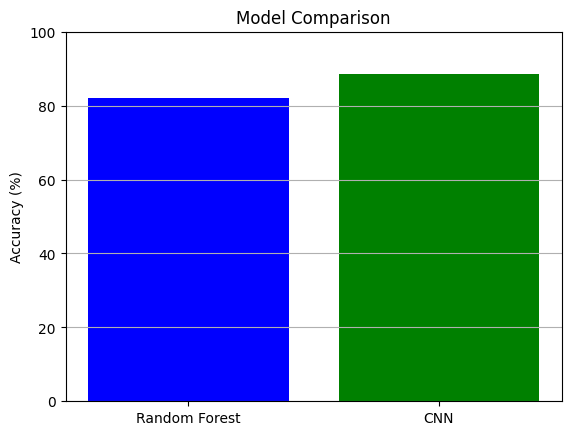

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Normalize image data
X_train_raw_normalized = X_train_raw / 255.0
X_test_raw_normalized = X_test_raw / 255.0

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=len(class_names))
y_test_cat = to_categorical(y_test, num_classes=len(class_names))

# CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train_raw_normalized.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_history = cnn_model.fit(X_train_raw_normalized, y_train_cat, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_raw_normalized, y_test_cat, verbose=0)
print(f"CNN Accuracy: {cnn_accuracy * 100:.2f}%")

# Compare with RF
rf_accuracy = accuracy_score(y_test, y_pred)

# Plot comparison
plt.bar(['Random Forest', 'CNN'], [rf_accuracy * 100, cnn_accuracy * 100], color=['blue', 'green'])
plt.ylabel('Accuracy (%)')
plt.title('Model Comparison')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


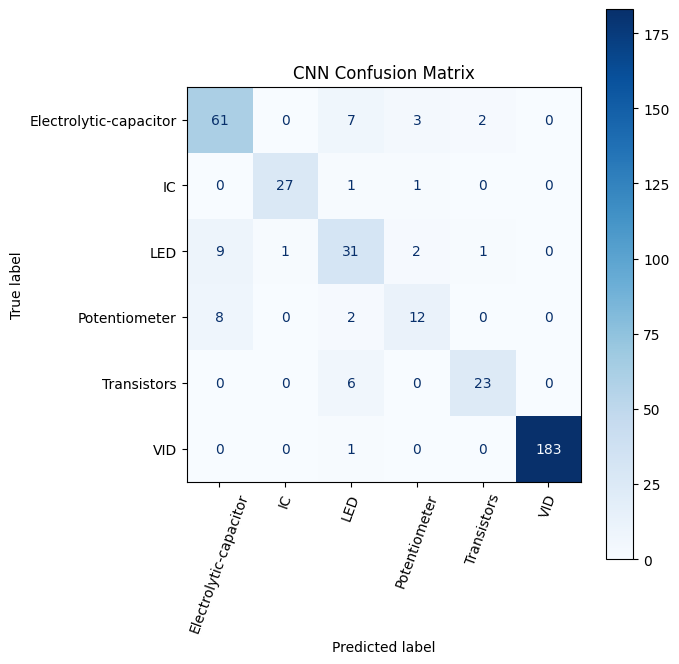

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict class probabilities
y_pred_probs = cnn_model.predict(X_test_raw_normalized)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create and customize plot
fig, ax = plt.subplots(figsize=(7, 7))  # Increase figure size for more space
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=70)  # Rotate x-tick labels for clarity
plt.title("CNN Confusion Matrix")
plt.tight_layout()
plt.show()


Saving potentiometer035_jpg.rf.ea4071c8820f39840894e679b69eef47.jpg to potentiometer035_jpg.rf.ea4071c8820f39840894e679b69eef47.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


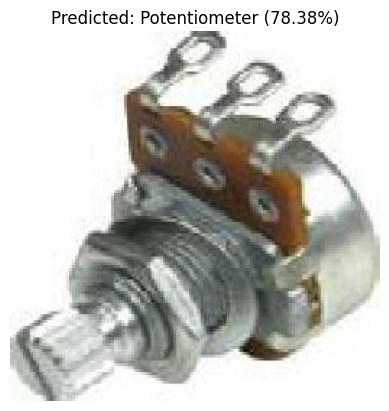

In [18]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

# Upload image
uploaded = files.upload()
uploaded_filename = list(uploaded.keys())[0]

# Load and preprocess image for CNN (resize to match training input shape)
img = image.load_img(uploaded_filename, target_size=(X_train_raw.shape[1], X_train_raw.shape[2]))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict with CNN
cnn_prediction = cnn_model.predict(img_array)
predicted_class_index = np.argmax(cnn_prediction[0])
prediction_percentage = cnn_prediction[0][predicted_class_index] * 100

# Display image and prediction
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class_index]} ({prediction_percentage:.2f}%)")
plt.axis('off')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    # Use X_test_raw to access the original image
    img = X_test_raw[i]
    plt.imshow(img) # No need to reshape, X_test_raw already contains image data
    plt.title(f"True: {class_names[y_test[i]]} | Predicted: {class_names[y_pred[i]]}")
    plt.axis('off')
    plt.show()

from google.colab import files

uploaded = files.upload()
# Get the filename of the uploaded image
uploaded_filename = list(uploaded.keys())[0]

# Preprocess the uploaded image
uploaded_img, uploaded_edge_features = preprocess_image(uploaded_filename)

# Extract features from the uploaded image
uploaded_features = extract_combined_features([uploaded_img]) # Note: extract_combined_features expects a list of images

# Make prediction on the uploaded image
uploaded_prediction = clf.predict(uploaded_features)


# Get prediction probabilities
uploaded_probabilities = clf.predict_proba(uploaded_features)[0]

# Get the predicted class index
predicted_class_index = uploaded_prediction[0]

# Get the prediction percentage for the predicted class
prediction_percentage = uploaded_probabilities[predicted_class_index] * 100

# Display the uploaded image and the prediction with percentage
plt.imshow(uploaded_img)
plt.title(f"Predicted: {class_names[predicted_class_index]} ({prediction_percentage:.2f}%)")
plt.axis('off')
plt.show()
